In [126]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools
import spacy
import nltk
%matplotlib inline

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [129]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [131]:
# dataframe display options
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)

# Problem Definition
<img src='form2.png'>

> The Objective of the project is to use Natural Language Processing on two fields entered by the user ("event title" and "additional info") to guide the user into selecting the correct category.
+ **"Event type" (category)** is a key field used by the company to match events and the capabilities of their pool of photographers.

# Problem Definition

Classification task: Predicting discrete-valued quantity $y$
+ Multi-class $ y \in \{1,2,3 \ldots k\}$ 


# Data Acquisition

<img src='data.png'>

In order to validate the possibility of a project I scraped information on 100 events. Links to the events were provided by the company.

In [699]:
def search_titles(df, expression):
    categories = df[df['category'].str.contains(expression, regex=True) == True]['category']
    idxs = df[df['category'].str.contains(expression, regex=True) == True].index
    print(categories)
    return idxs

def update_category(df, indices, category_title):
    for i in indices:
        df.loc[i, 'category'] = category_title

In [702]:
b = search_titles(g, r'baptism')

Series([], Name: category, dtype: object)


In [125]:
update_category(g, b, 'life celebration')

## After Categories were regrouped

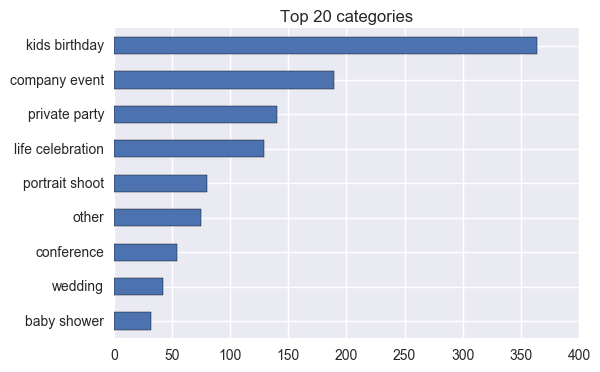

In [150]:
g['category'].value_counts()[:20][::-1].plot(kind='barh');
plt.title("Top 20 categories");

In [728]:
## Pickle data after cleanup
with open('events.pickle', 'wb') as f:
    pickle.dump(g, f)

In [201]:
reset -fs

# Loading events dataframe from pickled object

In [8]:
with open('events.pickle', 'rb') as f:
    g = pickle.load(f) 

In [9]:
categories = g.category.unique()
print("Number of categories: {}".format(len(categories)))

Number of categories: 9


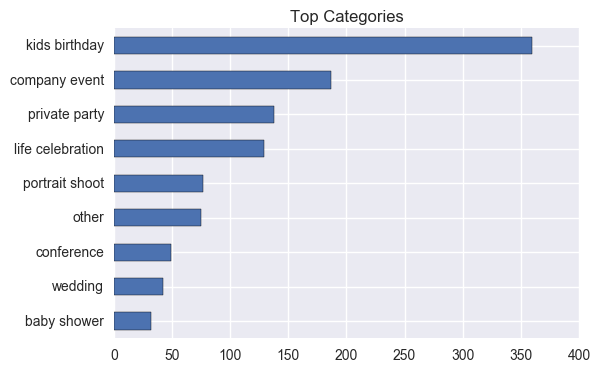

In [10]:
g['category'].value_counts()[:20][::-1].plot(kind='barh');
plt.title("Top Categories");

In [11]:
g['category'].value_counts()[:20]

kids birthday       360
company event       187
private party       138
life celebration    129
portrait shoot      77 
other               75 
conference          49 
wedding             42 
baby shower         32 
Name: category, dtype: int64

In [12]:
g.tail()

,album_ptr_id,title,additional_info,category,id
1100,560606.0,california cannabis industry association,"staged photographer for a step and repeat section, then scrolling photography after that.",company event,d2651246d360450aa29f3cb58b0ef6a8
1101,562327.0,arian's 1st birthday,NaN,kids birthday,08a7e7a3a3294f148aeb606777a7f552
1102,562452.0,nikhil's first birthday,NaN,kids birthday,27d88c2e30f34e32b6a1636ee2d18d17
1103,562658.0,krish and ishan birthday bash,"birthday party of a 2 year old and a 5 year old boys. some family portraits, solo of birthday kids, decorations, photo also with grandparents (focus on them a bit), focus on kids together too, cake cutting & family portraits in front of cake, theme of birthday party is bubbles! professional bubble maker will be there and would love photos of this",kids birthday,aa03bc2d11b443978a5d40dd7eb46253
1104,567831.0,a to z,this is an informal reception at our apartment complex before we have a wedding. we would like to spend the first 1-2 hours on portraits of just the two of us at nice spots around our apartment complex or any other ideas you have. we would like some nice portraits. then capture a bit of the event.,life celebration,76fb502fff584f0da0e812a449bd44be


# EDA

In [13]:
length = g[['title', 'additional_info', 'category']].copy()

In [14]:
length['title'][0]

'mustache movember eversnap party'

### How many characters are in "title" and "additional_info"?

In [53]:
length['title_length'] = length['title'].map(lambda text: len(str(text)))
length.head()

,title,additional_info,category,title_length
0,mustache movember eversnap party,step and repeat banner shots plus party photos,private party,32
1,shilpi's baby shower,NaN,other,20
2,"caleb's cat in the hat"" 1st birthday at superf...",NaN,kids birthday,53
3,michele's bridal shower,"this is the club house at sorrento, dublin ran...",life celebration,23
4,vihaan 1st birthday party,we would also like the photographer to take ca...,kids birthday,25


In [54]:
length['additional_info_length'] = length['additional_info'].map(lambda text: len(str(text)))
length.head()

,title,additional_info,category,title_length,additional_info_length
0,mustache movember eversnap party,step and repeat banner shots plus party photos,private party,32,46
1,shilpi's baby shower,NaN,other,20,3
2,"caleb's cat in the hat"" 1st birthday at superf...",NaN,kids birthday,53,3
3,michele's bridal shower,"this is the club house at sorrento, dublin ran...",life celebration,23,81
4,vihaan 1st birthday party,we would also like the photographer to take ca...,kids birthday,25,130


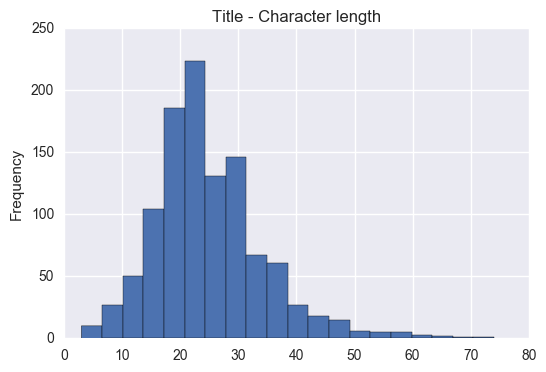

In [55]:
length.title_length.plot(bins=20, kind='hist');
plt.title("Title - Character length");

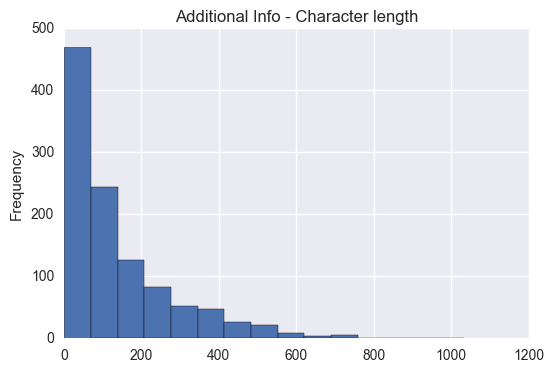

In [56]:
length.additional_info_length.plot(bins=15, kind='hist');
plt.title("Additional Info - Character length");

> We can see that "additional info" is an optional field and that overall length of each of the samples is small.

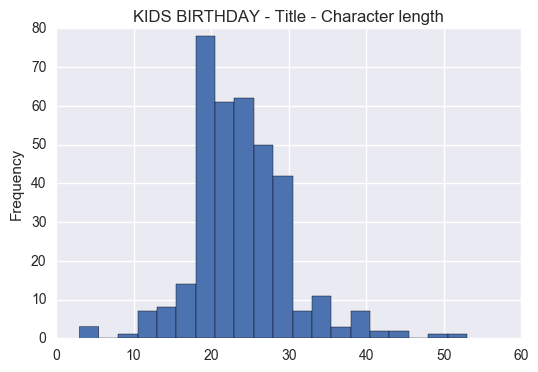

In [57]:
length[length["category"] == 'kids birthday']["title_length"].plot(bins=20, kind='hist');
plt.title("KIDS BIRTHDAY - Title - Character length");